In [2]:
# Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glicko2 import Player


# Import csv file

fighter_df = pd.read_csv('C:/Users/12152/Box/Other/full_fight_df.csv')

In [ ]:
from datetime import timedelta

# Set parameters
decay_rate = 5              # Elo points per 120 days
period_days = 120           # Length of decay period
baseline_elo = 1500         # Starting Elo

elo_ratings = {}            # Maps fighter to current Elo
last_fight_date = {}        # Maps fighter to last fight date
elo_history = []

for _, row in fighter_df.sort_values('date').iterrows():
    f1, f2 = row['fighter'], row['opponent']
    outcome = row['result']
    fight_date = pd.to_datetime(row['date'])

    # Initialize fighters
    for fighter in [f1, f2]:
        if fighter not in elo_ratings:
            elo_ratings[fighter] = baseline_elo
            last_fight_date[fighter] = fight_date

    # Apply decay for inactivity before this fight
    for fighter in [f1, f2]:
        days_inactive = (fight_date - last_fight_date[fighter]).days
        decay_periods = max(0, days_inactive // period_days)
        elo_ratings[fighter] -= decay_periods * decay_rate
        elo_ratings[fighter] = max(1300, elo_ratings[fighter])  # optional floor

    # Elo update logic (basic version)
    ra, rb = elo_ratings[f1], elo_ratings[f2]
    k = 32

    ea = 1 / (1 + 10 ** ((rb - ra) / 400))
    eb = 1 - ea

    if outcome == 'Win':
        sa, sb = 1.0, 0.0
    elif outcome == 'Loss':
        sa, sb = 0.0, 1.0
    else:
        sa = sb = 0.5

    elo_ratings[f1] += k * (sa - ea)
    elo_ratings[f2] += k * (sb - eb)

    # Update last fight dates
    last_fight_date[f1] = fight_date
    last_fight_date[f2] = fight_date

    # Store history
    elo_history.append({
        'date': fight_date,
        'fighter': f1,
        'opponent': f2,
        'elo': elo_ratings[f1],
        'result': outcome
    })


In [ ]:
elo_df = pd.DataFrame(elo_history)

In [ ]:
max_elo_df = (
    elo_df.groupby('fighter')['elo']
    .max()
    .sort_values(ascending=False)
    .rename('max_elo')
    .round(2)
    .reset_index()
)

print(max_elo_df.head(25))

In [31]:
# Preprocessing
fighter_df['date'] = pd.to_datetime(fighter_df['date'])
fighter_df = fighter_df.sort_values('date')

# Elo hyperparameters
baseline_elo = 1500
decay_lambda = 0.00015
k = 44
bonus_finish = 4
bonus_title = 12
min_elo = 1300  # optional floor

# Track Elo and fight dates
elo_ratings = {}
last_fight_date = {}
elo_history = []

# Elo update loop
for _, row in fighter_df.iterrows():
    f1 = row['fighter']
    f2 = row['opponent']
    date = row['date']
    outcome = str(row['result']).strip().lower()
    is_finish = row.get('is_finish', False)
    is_title = row.get('is_title', False)

    for fighter in [f1, f2]:
        if fighter not in elo_ratings:
            elo_ratings[fighter] = baseline_elo
            last_fight_date[fighter] = date

        # Apply decay
        days_inactive = (date - last_fight_date[fighter]).days
        if days_inactive > 0:
            decay_factor = np.exp(-decay_lambda * days_inactive)
            elo_ratings[fighter] = baseline_elo + (elo_ratings[fighter] - baseline_elo) * decay_factor
            elo_ratings[fighter] = max(min_elo, elo_ratings[fighter])  # clip at floor

    # Extract ratings
    ra, rb = elo_ratings[f1], elo_ratings[f2]
    
    # Store pre-fight ratings before Elo update
    fighter_elo_pre, opponent_elo_pre = ra, rb
    
    ea = 1 / (1 + 10 ** ((rb - ra) / 400))
    eb = 1 - ea

    # Assign scores
    if outcome == 'win':
        sa, sb = 1.0, 0.0
    elif outcome == 'loss':
        sa, sb = 0.0, 1.0
    else:
        sa = sb = 0.5

    # Bonus scaling (only for winner)
    bonus_a = 0
    if sa == 1.0:
        if is_finish:
            bonus_a += bonus_finish
        if is_title:
            bonus_a += bonus_title

    # Update Elo ratings
    elo_ratings[f1] += k * (sa - ea) + bonus_a
    elo_ratings[f2] += k * (sb - eb)

    # Update last fight date
    last_fight_date[f1] = date
    last_fight_date[f2] = date

    # Log both fighters
    for fighter, opponent, rating, score, bonus, pre_elo in [
        (f1, f2, elo_ratings[f1], sa, bonus_a, fighter_elo_pre),
        (f2, f1, elo_ratings[f2], sb, 0, opponent_elo_pre)
    ]:
        elo_history.append({
            'date': date,
            'fighter': fighter,
            'opponent': opponent,
            'elo': rating,
            'elo_pre': pre_elo,
            'result': 'win' if score == 1 else 'loss' if score == 0 else 'draw',
            'is_finish': is_finish if fighter == f1 else False,
            'is_title': is_title,
            'bonus': bonus
        })

# Convert to DataFrame
elo_decay_df = pd.DataFrame(elo_history)


In [91]:
final_elos = (
    elo_decay_df.groupby('fighter')['elo']
    .last()
    .sort_values(ascending=False)
    .rename('final_elo')
)

print(final_elos.head(30))

fighter
Islam Makhachev           2011.134979
Khabib Nurmagomedov       1972.057233
Belal Muhammad            1955.824734
Georges St-Pierre         1955.046245
Jon Jones                 1940.792678
Dricus du Plessis         1929.280083
Merab Dvalishvili         1923.398078
Magomed Ankalaev          1919.371642
Shavkat Rakhmonov         1898.521568
Arman Tsarukyan           1897.944650
Ilia Topuria              1895.540312
Movsar Evloev             1884.504473
Francis Ngannou           1882.368121
Charles Oliveira          1879.281504
Alexandre Pantoja         1874.810175
Khamzat Chimaev           1874.514960
Zhang Weili               1866.171565
Daniel Cormier            1859.342425
Alexander Volkanovski     1858.306163
Alex Pereira              1856.758716
Sean Brady                1852.104082
Max Holloway              1851.233857
Tom Aspinall              1849.775607
Ciryl Gane                1849.396450
Magomed Magomedkerimov    1848.763909
Nassourdine Imavov        1845.707017
Jack

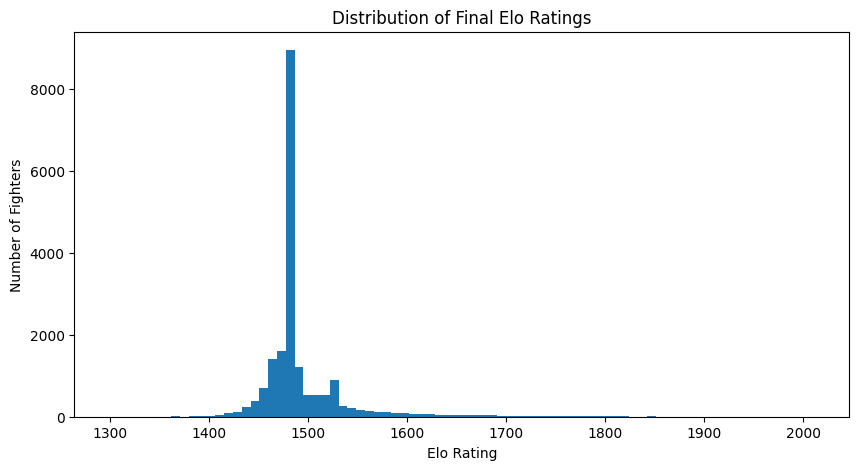

In [99]:
plt.figure(figsize=(10, 5))
plt.hist(final_elos, 
         bins = 80)
plt.title("Distribution of Final Elo Ratings")
plt.xlabel("Elo Rating")
plt.ylabel("Number of Fighters")
plt.show()

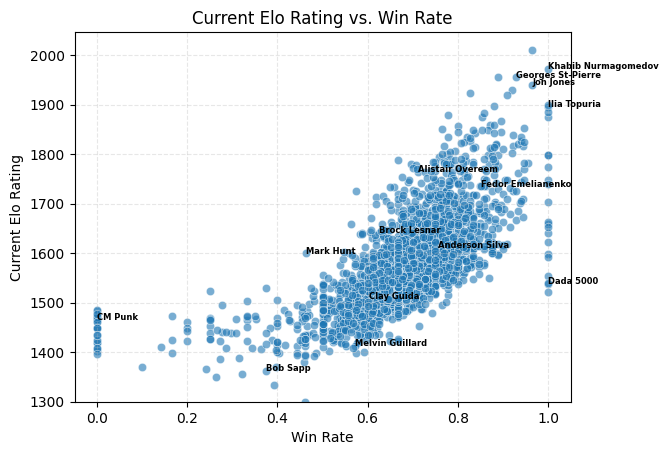

In [135]:
# Create win rates
fighter_stats = fighter_df.groupby('fighter').agg(
    wins=('result', lambda x: (x == 'Win').sum()),
    total=('result', 'count')
)
fighter_stats['win_rate'] = fighter_stats['wins'] / fighter_stats['total']

# Merge with Elo
fighter_stats = fighter_stats.merge(final_elos, left_index=True, right_index=True)

# Optional: scatterplot
import seaborn as sns

# Fighters you want to label (use exact names from your dataset)
highlighted = ['Jon Jones', 'Fedor Emelianenko', 'Anderson Silva', 'Alistair Overeem', 'Georges St-Pierre', 'Mark Hunt', 'Khabib Nurmagomedov', 'Clay Guida', 'Melvin Guillard', 'Bob Sapp', 'Brock Lesnar', 'CM Punk', 'Dada 5000', 'Ilia Topuria']

for name in highlighted:
    if name in fighter_stats.index:
        row = fighter_stats.loc[name]
        plt.text(row['win_rate'], row['final_elo'], name, fontsize=6, weight='semibold')

sns.scatterplot(data=fighter_stats, x='win_rate', y='final_elo', alpha=0.6)
plt.title("Current Elo Rating vs. Win Rate")
plt.xlabel("Win Rate")
plt.ylabel("Current Elo Rating")
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(bottom=1300)
plt.savefig("elo_vs_winrate.png", dpi=300, bbox_inches='tight')
plt.show()


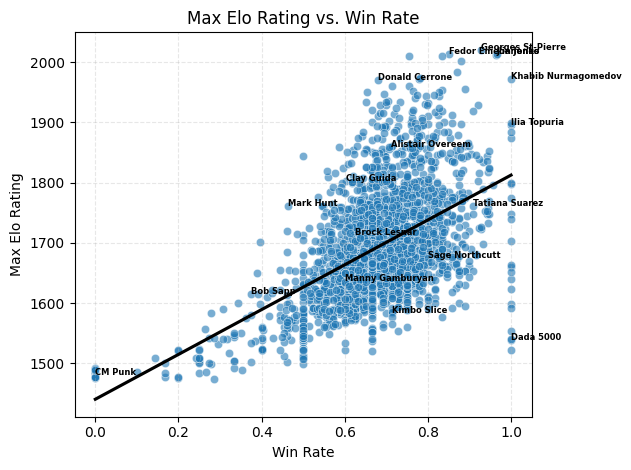

In [ ]:
max_elo_df = elo_decay_df.groupby('fighter')['elo'].max().reset_index().rename(columns={'elo': 'max_elo'})

fight_stats = fighter_df.groupby('fighter').agg(
    wins=('result', lambda x: (x == 'Win').sum()),
    total=('result', 'count')
)
fight_stats['win_rate'] = fight_stats['wins'] / fight_stats['total']

max_fighter_stats = fight_stats.merge(max_elo_df, on='fighter', how='inner')

sns.scatterplot(data=max_fighter_stats, x='win_rate', y='max_elo', alpha=0.6)

highlighted = [
    'Jon Jones', 'Fedor Emelianenko', 'Alistair Overeem',
    'Georges St-Pierre', 'Mark Hunt', 'Khabib Nurmagomedov', 'Clay Guida',
    'Bob Sapp', 'Brock Lesnar', 'CM Punk', 'Dada 5000', 'Ilia Topuria', 'Sage Northcutt', 'Kimbo Slice', 'Tatiana Suarez', 'Donald Cerrone', 'Manny Gamburyan'
]

for name in highlighted:
    if name in max_fighter_stats['fighter'].values:
        row = max_fighter_stats[max_fighter_stats['fighter'] == name].iloc[0]
        plt.text(row['win_rate'], row['max_elo'], name, fontsize=6, weight='semibold')
sns.regplot(data=max_fighter_stats, x='win_rate', y='max_elo', scatter=False, ci=None, color='black')
plt.title("Max Elo Rating vs. Win Rate")
plt.xlabel("Win Rate")
plt.ylabel("Max Elo Rating")
plt.grid(True)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [39]:
#Results without decay to display difference in Elo ratings using decay method
# Preprocessing
fighter_df['date'] = pd.to_datetime(fighter_df['date'])
fighter_df = fighter_df.sort_values('date')

# Elo hyperparameters
baseline_elo = 1500
# decay_lambda = 0.00015
k = 44
bonus_finish = 4
bonus_title = 12
# min_elo = 1300  # optional floor

# Track Elo and fight dates
elo_ratings = {}
last_fight_date = {}
elo_history = []

# Elo update loop
for _, row in fighter_df.iterrows():
    f1 = row['fighter']
    f2 = row['opponent']
    date = row['date']
    outcome = str(row['result']).strip().lower()
    is_finish = row.get('is_finish', False)
    is_title = row.get('is_title', False)

    for fighter in [f1, f2]:
        if fighter not in elo_ratings:
            elo_ratings[fighter] = baseline_elo
            last_fight_date[fighter] = date

            elo_ratings[fighter] = baseline_elo + (elo_ratings[fighter] - baseline_elo)

    # Extract ratings
    ra, rb = elo_ratings[f1], elo_ratings[f2]
    
    # Store pre-fight ratings before Elo update
    fighter_elo_pre, opponent_elo_pre = ra, rb
    
    ea = 1 / (1 + 10 ** ((rb - ra) / 400))
    eb = 1 - ea

    # Assign scores
    if outcome == 'win':
        sa, sb = 1.0, 0.0
    elif outcome == 'loss':
        sa, sb = 0.0, 1.0
    else:
        sa = sb = 0.5

    # Bonus scaling (only for winner)
    bonus_a = 0
    if sa == 1.0:
        if is_finish:
            bonus_a += bonus_finish
        if is_title:
            bonus_a += bonus_title

    # Update Elo ratings
    elo_ratings[f1] += k * (sa - ea) + bonus_a
    elo_ratings[f2] += k * (sb - eb)

    # Update last fight date
    last_fight_date[f1] = date
    last_fight_date[f2] = date

    # Log both fighters
    for fighter, opponent, rating, score, bonus, pre_elo in [
        (f1, f2, elo_ratings[f1], sa, bonus_a, fighter_elo_pre),
        (f2, f1, elo_ratings[f2], sb, 0, opponent_elo_pre)
    ]:
        elo_history.append({
            'date': date,
            'fighter': fighter,
            'opponent': opponent,
            'elo': rating,
            'elo_pre': pre_elo,
            'result': 'win' if score == 1 else 'loss' if score == 0 else 'draw',
            'is_finish': is_finish if fighter == f1 else False,
            'is_title': is_title,
            'bonus': bonus
        })

# Convert to DataFrame
elo_no_decay_df = pd.DataFrame(elo_history)

In [40]:
max_elo_no_decay_df = (
    elo_no_decay_df.groupby('fighter')['elo']
    .max()
    .sort_values(ascending=False)
    .rename('max_elo')
    .round(2)
    .reset_index()
)

print(max_elo_no_decay_df.head(25))

                  fighter  max_elo
0               Jon Jones  2267.61
1       Georges St-Pierre  2222.72
2         Islam Makhachev  2209.47
3          Daniel Cormier  2183.05
4            Kamaru Usman  2173.85
5       Fedor Emelianenko  2166.34
6          Anderson Silva  2165.40
7     Khabib Nurmagomedov  2157.26
8   Alexander Volkanovski  2154.12
9        Charles Oliveira  2143.23
10           Leon Edwards  2137.93
11           Stipe Miocic  2136.01
12         Belal Muhammad  2127.22
13         Dustin Poirier  2122.96
14           Max Holloway  2114.00
15             Ryan Bader  2113.53
16      Aljamain Sterling  2107.47
17        Israel Adesanya  2106.16
18              José Aldo  2099.64
19         Gegard Mousasi  2099.48
20          Tony Ferguson  2089.06
21          Tyron Woodley  2088.08
22         Donald Cerrone  2085.38
23         Justin Gaethje  2080.23
24        Francis Ngannou  2076.07


In [70]:
# Compute per-fight gap
merge_decay_no_decay_df = pd.merge(
    elo_decay_df,
    elo_no_decay_df,
    on=['fighter', 'date'],
    suffixes=('_decay', '_no_decay')
)

merge_decay_no_decay_df['elo_gap'] = (
    merge_decay_no_decay_df['elo_decay'] - merge_decay_no_decay_df['elo_no_decay']
).abs()  # Take absolute value before grouping

avg_gap = merge_decay_no_decay_df.groupby('fighter')['elo_gap'].mean().reset_index()
avg_gap = avg_gap.sort_values('elo_gap', ascending=False)

avg_gap.head(10)

# Filter for positive (non-zero) gaps only
avg_gap_nonzero = avg_gap[avg_gap['elo_gap'] > 0]

# Sort to get the smallest non-zero gaps
avg_gap_nonzero = avg_gap_nonzero.sort_values('elo_gap', ascending=True)

# Show the top 10
avg_gap_nonzero.head(20)


,fighter,elo_gap
8645,Joe DeFuria,0.000011
3666,Corey Edwards,0.000015
9238,Jorge Serratos,0.000188
1885,Baoleerdalai Er Da Bao,0.000208
6329,Gary Mikayelyan,0.000216
15081,Ricky Seleuce,0.000265
5066,Drago Drago,0.000330
8776,Joey Estrada,0.000352
6351,Gavin Hesson,0.000408
3733,Craig Pumphrey,0.000425


In [75]:
# Get max gap per fighter
max_gap = merge_decay_no_decay_df.groupby('fighter')['elo_gap'].apply(lambda x: x.abs().max()).reset_index()
max_gap = max_gap.sort_values('elo_gap', ascending=False)
max_gap.head(2000)

,fighter,elo_gap
9047,Jon Jones,340.354356
16968,Stipe Miocic,291.323676
6422,Georges St-Pierre,284.622572
15684,Ryan Bader,267.420328
5928,Fedor Emelianenko,265.395087
...,...,...
1365,Anshul Jubli,35.126348
11088,Liana Jojua,35.115443
2895,Carmelo Marrero,35.102585
11498,Magomed Malikov,35.095805


In [81]:
#Compare fighters with decay and without decay

#Filter for fighters
fighters = ['Jon Jones', 'Conor McGregor', 'Aleksei Oleinik']

decay_sub = elo_decay_df[elo_decay_df['fighter'].isin(fighters)].copy()
nodc_sub = elo_no_decay_df[elo_no_decay_df['fighter'].isin(fighters)].copy()


#Rename columns 
decay_sub.rename(columns={'elo': 'elo_decay'}, inplace=True)
nodc_sub.rename(columns={'elo': 'elo_no_decay'}, inplace=True)


#Merge dataframes on date
merged = pd.merge(
    decay_sub[['fighter', 'date', 'elo_decay']],
    nodc_sub[['fighter', 'date', 'elo_no_decay']],
    on=['fighter', 'date'],
    how='outer'
).sort_values(['fighter', 'date'])


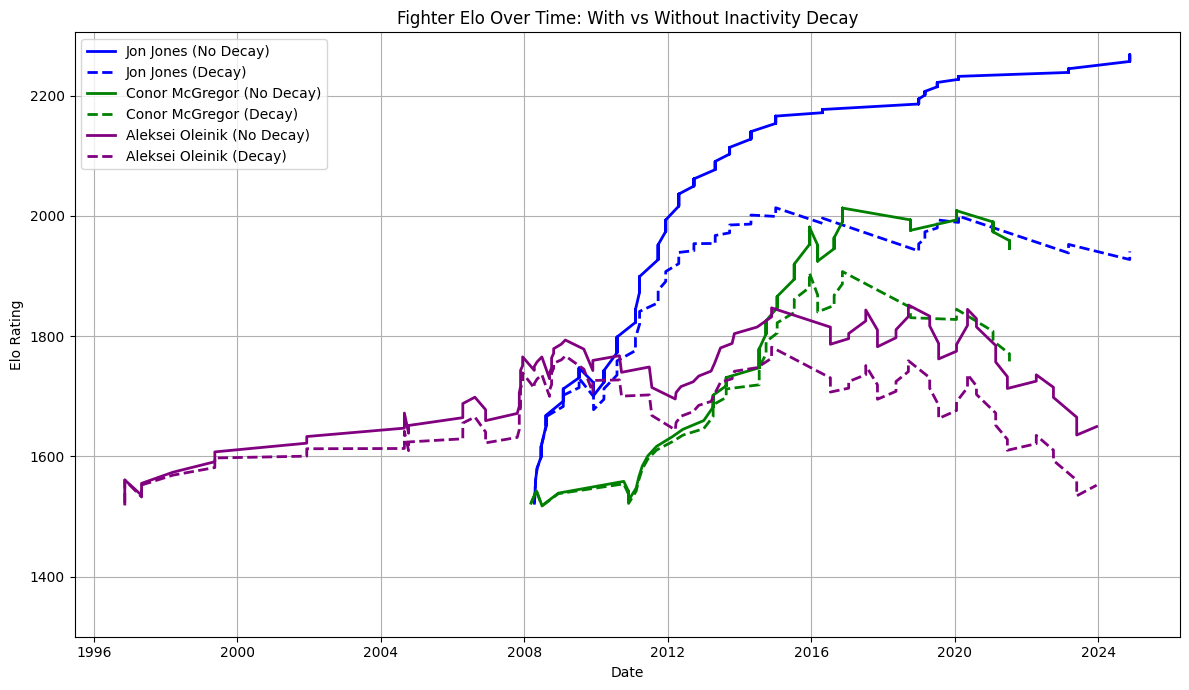

In [82]:
#Create plot
color_map = {
    'Jon Jones': 'blue',
    'Aleksei Oleinik': 'purple',
    'Conor McGregor': 'green'
}

plt.figure(figsize=(12, 7))

for fighter in fighters:
    data = merged[merged['fighter'] == fighter]
    base_color = color_map.get(fighter, 'gray')  # fallback to gray if not in map

    plt.plot(
        data['date'],
        data['elo_no_decay'],
        label=f'{fighter} (No Decay)',
        color=base_color,
        linewidth=2
    )

    plt.plot(
        data['date'],
        data['elo_decay'],
        label=f'{fighter} (Decay)',
        color=base_color,
        linestyle='--',  # Dashed line for decay
        linewidth=2
    )

plt.title("Fighter Elo Over Time: With vs Without Inactivity Decay")
plt.xlabel("Date")
plt.ylabel("Elo Rating")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(bottom=1300)
plt.show()

In [ ]:
# Best Fights of All Time
# Step 1: Prepare two mirrored DataFrames
df1 = elo_decay_df[['date', 'fighter', 'opponent', 'elo_pre']].copy()

df2 = df1.rename(columns={
    'fighter': 'opponent',
    'opponent': 'fighter',
    'elo_pre': 'opponent_elo_pre'
})

# Step 2: Merge to get both fighter's elo_pre in the same row
merged = pd.merge(df1, df2, on=['date', 'fighter', 'opponent'])

# Step 3: Create unordered fighter pair to remove mirrored duplicates
merged['fighter_pair'] = merged.apply(
    lambda x: tuple(sorted([x['fighter'], x['opponent']])),
    axis=1
)

# Step 4: Drop duplicated fights based on date and unordered pair
merged_unique = merged.drop_duplicates(subset=['date', 'fighter_pair']).drop(columns='fighter_pair')

# Step 5: Calculate combined Elo before fight
merged_unique['combined_elo_pre'] = merged_unique['elo_pre'] + merged_unique['opponent_elo_pre']

# Step 6: Sort and view top fights
top_combined = merged_unique.sort_values(by='combined_elo_pre', ascending=False)

# Optional: Select columns to view
top_combined = top_combined[['date', 'fighter', 'elo_pre', 'opponent', 'opponent_elo_pre', 'combined_elo_pre']]

print(top_combined.head(20))


             date              fighter      elo_pre                  opponent  \
142578 2023-02-12      Islam Makhachev  1933.911258     Alexander Volkanovski   
145658 2023-10-21      Islam Makhachev  1961.464998     Alexander Volkanovski   
83286  2013-11-16    Georges St-Pierre  1989.360034           Johny Hendricks   
63324  2011-04-30    Georges St-Pierre  1967.270592              Jake Shields   
21258  2004-12-31    Fedor Emelianenko  1922.599101  Antônio Rodrigo Nogueira   
92024  2015-01-03       Daniel Cormier  1890.698725                 Jon Jones   
117336 2018-07-07       Daniel Cormier  1944.295293              Stipe Miocic   
99000  2015-12-19     Rafael dos Anjos  1902.947168            Donald Cerrone   
86404  2014-04-26            Jon Jones  1969.216358           Glover Teixeira   
141306 2022-10-22      Islam Makhachev  1892.123876          Charles Oliveira   
125452 2019-09-07  Khabib Nurmagomedov  1922.123240            Dustin Poirier   
72846  2012-07-07       Ande